In [1]:
import asyncio
import time
import logging

import vector; vector.register_awkward()

import cabinetry
from coffea.nanoevents.schemas.base import BaseSchema, zip_forms
from coffea.nanoevents import NanoAODSchema
from coffea import processor
from coffea.nanoevents.methods import base, vector
from coffea.nanoevents import transforms
import awkward as ak
import numpy as np
import hist
import json
import matplotlib.pyplot as plt
import uproot

import torch
import onnx

import utils

logging.getLogger("cabinetry").setLevel(logging.INFO)

In [2]:
N_FILES_MAX_PER_SAMPLE = 10
NUM_CORES = 16
CHUNKSIZE = 500_000
IO_FILE_PERCENT = 4
USE_DASK = True
AF = "coffea_casa"

In [3]:
# functions creating systematic variations
def flat_variation(ones):
    # 0.1% weight variations
    return (1.0 + np.array([0.001, -0.001], dtype=np.float32)) * ones[:, None]


def btag_weight_variation(i_jet, jet_pt):
    # weight variation depending on i-th jet pT (10% as default value, multiplied by i-th jet pT / 50 GeV)
    return 1 + np.array([0.1, -0.1]) * (ak.singletons(jet_pt[:, i_jet]) / 50).to_numpy()


def jet_pt_resolution(pt):
    # normal distribution with 5% variations, shape matches jets
    counts = ak.num(pt)
    pt_flat = ak.flatten(pt)
    resolution_variation = np.random.normal(np.ones_like(pt_flat), 0.05)
    return ak.unflatten(resolution_variation, counts)


In [4]:
def training_filter(jets, electrons, muons, genparts):
    #### filter genPart to valid matching candidates ####

    # get rid of particles without parents
    genpart_parent = genparts.distinctParent
    genpart_filter = np.invert(ak.is_none(genpart_parent, axis=1))
    genparts = genparts[genpart_filter]
    genpart_parent = genparts.distinctParent

    # ensure that parents are top quark or W
    genpart_filter2 = ((np.abs(genpart_parent.pdgId)==6) | (np.abs(genpart_parent.pdgId)==24))
    genparts = genparts[genpart_filter2]

    # ensure particle itself is a quark
    genpart_filter3 = ((np.abs(genparts.pdgId)<7) & (np.abs(genparts.pdgId)>0))
    genparts = genparts[genpart_filter3]

    # get rid of duplicates
    genpart_filter4 = genparts.hasFlags("isLastCopy")
    genparts = genparts[genpart_filter4]
            
        
    #### get jet-level labels and filter events to training set
        
    # match jets to nearest valid genPart candidate
    nearest_genpart = jets.nearest(genparts, threshold=0.4)
    nearest_parent = nearest_genpart.distinctParent # parent of matched particle

    parent_pdgid = nearest_parent.pdgId # pdgId of parent particle
    grandchild_pdgid = nearest_parent.distinctChildren.distinctChildren.pdgId # pdgId of particle's parent's grandchildren

    grandchildren_flat = np.abs(ak.flatten(grandchild_pdgid,axis=-1)) # flatten innermost axis for convenience

    # if particle has a cousin that is a lepton
    has_lepton_cousin = (ak.sum(((grandchildren_flat%2==0) & (grandchildren_flat>10) & (grandchildren_flat<19)),
                                axis=-1)>0)
    # if particle has a cousin that is a neutrino
    has_neutrino_cousin = (ak.sum(((grandchildren_flat%2==1) & (grandchildren_flat>10) & (grandchildren_flat<19)),
                                  axis=-1)>0)

    # if a particle has a lepton cousin and a neutrino cousin
    has_both_cousins = ak.fill_none((has_lepton_cousin & has_neutrino_cousin), False).to_numpy()

    # get labels from parent pdgId (fill none with 100 to filter out events with those jets)
    labels = np.abs(ak.fill_none(parent_pdgid,100).to_numpy())
    labels[has_both_cousins] = -6 # assign jets with both cousins as top1 (not necessarily antiparticle)

    training_event_filter = (np.sum(labels,axis=1)==48) # events with a label sum of 48 have the correct particles
            
    # filter events
    jets = jets[training_event_filter]
    electrons = electrons[training_event_filter]
    muons = muons[training_event_filter]
    labels = labels[training_event_filter]
    
    return jets, electrons, muons, labels
    

def get_training_set(jets, electrons, muons, labels):
    
    # permutations of jets to consider
    permutation_ind = np.array([[0,1,2,3],[0,1,3,2],[0,2,1,3],[0,3,1,2],
                                [0,2,3,1],[0,3,2,1],[2,0,1,3],[3,0,1,2],
                                [2,0,3,1],[3,0,2,1],[2,3,0,1],[3,2,0,1]])
    # corresponding jet labels to above permutations
    permutation_labels = np.array([[24,24,6,-6],[24,24,-6,6],[24,6,24,-6],[24,-6,24,6],
                                   [24,6,-6,24],[24,-6,6,24],[6,24,24,-6],[-6,24,24,6],
                                   [6,24,-6,24],[-6,24,6,24],[6,-6,24,24],[-6,6,24,24]])
    
    
    #### calculate features ####
    
    features = np.zeros((len(jets),12,19))
                        
    # grab lepton info
    lepton_eta = (ak.sum(electrons.eta,axis=-1) + ak.sum(muons.eta,axis=-1)).to_numpy().reshape((len(jets),1))
    lepton_phi = (ak.sum(electrons.phi,axis=-1) + ak.sum(muons.phi,axis=-1)).to_numpy().reshape((len(jets),1))
    lepton_mass = (ak.sum(electrons.mass,axis=-1) + ak.sum(muons.mass,axis=-1)).to_numpy().reshape((len(jets),1))
    
    # delta R between top1 and lepton
    features[:,:,0] = np.sqrt((lepton_eta - jets[:,permutation_ind[:,3]].eta)**2 + 
                              (lepton_phi - jets[:,permutation_ind[:,3]].phi)**2)

    # delta R between the two W
    features[:,:,1] = np.sqrt((jets[:,permutation_ind[:,0]].eta - jets[:,permutation_ind[:,1]].eta)**2 + 
                              (jets[:,permutation_ind[:,0]].phi - jets[:,permutation_ind[:,1]].phi)**2)

    # delta R between W and top2
    features[:,:,2] = np.sqrt((jets[:,permutation_ind[:,0]].eta - jets[:,permutation_ind[:,2]].eta)**2 + 
                              (jets[:,permutation_ind[:,0]].phi - jets[:,permutation_ind[:,2]].phi)**2)
    features[:,:,3] = np.sqrt((jets[:,permutation_ind[:,0]].eta - jets[:,permutation_ind[:,2]].eta)**2 + 
                              (jets[:,permutation_ind[:,1]].phi - jets[:,permutation_ind[:,2]].phi)**2)

    # delta phi between top1 and lepton
    features[:,:,4] = np.abs(lepton_phi - jets[:,permutation_ind[:,3]].phi)

    # delta phi between the two W
    features[:,:,5] = np.abs(jets[:,permutation_ind[:,0]].phi - jets[:,permutation_ind[:,1]].phi)

    # delta phi between W and top2
    features[:,:,6] = np.abs(jets[:,permutation_ind[:,0]].phi - jets[:,permutation_ind[:,2]].phi)
    features[:,:,7] = np.abs(jets[:,permutation_ind[:,1]].phi - jets[:,permutation_ind[:,2]].phi)

    # combined mass of top1 and lepton
    features[:,:,8] = lepton_mass + jets[:,permutation_ind[:,3]].mass

    # combined mass of W
    features[:,:,9] = jets[:,permutation_ind[:,0]].mass + jets[:,permutation_ind[:,1]].mass

    # combined mass of W and top2
    features[:,:,10] = jets[:,permutation_ind[:,0]].mass + jets[:,permutation_ind[:,1]].mass + jets[:,permutation_ind[:,2]].mass

    # pt of every jet
    features[:,:,11] = jets[:,permutation_ind[:,0]].pt
    features[:,:,12] = jets[:,permutation_ind[:,1]].pt
    features[:,:,13] = jets[:,permutation_ind[:,2]].pt
    features[:,:,14] = jets[:,permutation_ind[:,3]].pt

    # mass of every jet
    features[:,:,15] = jets[:,permutation_ind[:,0]].mass
    features[:,:,16] = jets[:,permutation_ind[:,1]].mass
    features[:,:,17] = jets[:,permutation_ind[:,2]].mass
    features[:,:,18] = jets[:,permutation_ind[:,3]].mass

    
    #### calculate combination-level labels ####
    
    # which combination does the truth label correspond to?
    which_combination = np.zeros(len(jets), dtype=int)
    # no correct matches
    which_anti_combination = np.zeros(labels.shape[0], dtype=int)
    for i in range(12):
        which_combination[(labels[:]==permutation_labels[i,:]).all(1)] = i
        which_anti_combination[np.invert((labels[:]==permutation_labels[i,:]).any(1))] = i

    # convert to combination-level truth label (-1, 0 or 1)
    which_combination = list(zip(range(len(jets),), which_combination))
    which_anti_combination = list(zip(range(labels.shape[0],), which_anti_combination))
    
    truth_labels = np.zeros((len(jets),12))
    for i,tpl in enumerate(which_combination):
        truth_labels[tpl]=1
    for i,tpl in enumerate(which_anti_combination):
        truth_labels[tpl]=-1
        
        
    #### flatten to combinations (easy to unflatten since each event always has 12 combinations) ####
    labels = truth_labels.reshape((truth_labels.shape[0]*truth_labels.shape[1],1))
    features = features.reshape((features.shape[0]*features.shape[1],features.shape[2]))    
        
    return features, labels



In [5]:
processor_base = processor.ProcessorABC
class JetClassifier(processor_base):
    def __init__(self, io_file_percent):
        self.io_file_percent = io_file_percent
    
    def process(self, events):
        
        process = events.metadata["process"]  # "ttbar" etc.
        variation = events.metadata["variation"]  # "nominal" etc.
        
        # normalization for MC
        x_sec = events.metadata["xsec"]
        nevts_total = events.metadata["nevts"]
        lumi = 3378 # /pb
        if process != "data":
            xsec_weight = x_sec * lumi / nevts_total
        else:
            xsec_weight = 1
            
        if process == "wjets":
            events.add_systematic("scale_var", "UpDownSystematic", "weight", flat_variation)
            
        events["pt_nominal"] = 1.0
        events["pt_scale_up"] = 1.03
        events["pt_res_up"] = jet_pt_resolution(events.Jet.pt)
        
        pt_variations = ["pt_nominal", "pt_scale_up", "pt_res_up"] if variation == "nominal" else ["pt_nominal"]
        for pt_var in pt_variations:
            
            selected_electrons = events.Electron[events.Electron.pt > 30]
            selected_muons = events.Muon[events.Muon.pt > 30]
            jet_filter = events.Jet.pt * events[pt_var] > 30
            selected_jets = events.Jet[jet_filter]
            selected_genpart = events.GenPart
            
            event_filters = ((ak.count(selected_electrons.pt, axis=1) + ak.count(selected_muons.pt, axis=1)) == 1)
            pt_var_modifier = events[pt_var] if "res" not in pt_var else events[pt_var][jet_filter]
            event_filters = event_filters & (ak.count(selected_jets.pt * pt_var_modifier, axis=1) >= 4)
            B_TAG_THRESHOLD = 0.8
            event_filters = event_filters & (ak.sum(selected_jets.btagCSVV2 >= B_TAG_THRESHOLD, axis=1) >= 1)
            
            # apply event filters
            selected_events = events[event_filters]
            selected_electrons = selected_electrons[event_filters]
            selected_muons = selected_muons[event_filters]
            selected_jets = selected_jets[event_filters]
            selected_genpart = selected_genpart[event_filters]
            
            ### only consider 4j2b region
            region_filter = ak.sum(selected_jets.btagCSVV2 > B_TAG_THRESHOLD, axis=1) >= 2
            selected_jets_region = selected_jets[region_filter][:,:4] # only keep top 4 jets
            selected_electrons_region = selected_electrons[region_filter]
            selected_muons_region = selected_muons[region_filter]
            selected_genpart_region = selected_genpart[region_filter]
            
            # filter events and calculate labels
            jets, electrons, muons, labels = training_filter(selected_jets_region, 
                                                             selected_electrons_region, 
                                                             selected_muons_region, 
                                                             selected_genpart_region)
            
            # calculate features and labels
            features, labels = get_training_set(jets, electrons, muons, labels)
            
        # features = np.ones(len(events))
        # labels = np.ones(len(events))
    
        output = {"nevents": {events.metadata["dataset"]: len(events)},
                  "features": {events.metadata["dataset"]: features.tolist()},
                  "labels": {events.metadata["dataset"]: labels.tolist()}}
            
        return output
        
    def postprocess(self, accumulator):
        return accumulator

In [6]:
fileset = utils.construct_fileset(N_FILES_MAX_PER_SAMPLE, use_xcache=False, json_file = 'ntuples_nanoaod_agc.json')
fileset_keys = list(fileset.keys())
for key in fileset_keys:
    if key!="ttbar__nominal":
        fileset.pop(key)

process =  ttbar
variation =  nominal
variation =  scaledown
variation =  scaleup
variation =  ME_var
variation =  PS_var
process =  single_top_s_chan
variation =  nominal
process =  single_top_t_chan
variation =  nominal
process =  single_top_tW
variation =  nominal
variation =  scaledown
variation =  scaleup
variation =  DS
process =  wjets
variation =  nominal


In [7]:
fileset

{'ttbar__nominal': {'files': ['https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19980_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1_00000_0000.root',
   'https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19980_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1_00000_0001.root',
   'https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19980_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1_00000_0002.root',
   'https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19980_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1_00000_0003.root',
   'https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19980_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1_00000_0004.

In [8]:
schema = NanoAODSchema
# executor = processor.FuturesExecutor(workers=NUM_CORES)
executor = processor.DaskExecutor(client=utils.get_client(AF))
run = processor.Runner(executor=executor, schema=schema, savemetrics=True, metadata_cache={}, chunksize=CHUNKSIZE)

In [9]:
filemeta = run.preprocess(fileset, treename="Events")

In [10]:
output, metrics = run(fileset, 
                      "Events", 
                      processor_instance = JetClassifier(IO_FILE_PERCENT))

In [11]:
features = np.array(output['features']['ttbar__nominal'])
labels = np.array(output['labels']['ttbar__nominal'])
labels = labels.reshape((len(labels),))

In [12]:
print(features.shape)
print(labels.shape)

(483804, 19)
(483804,)


In [13]:
all_correct = features[labels==1,:]
some_correct = features[labels==0,:]
none_correct = features[labels==-1,:]

In [14]:
import matplotlib.pyplot as plt

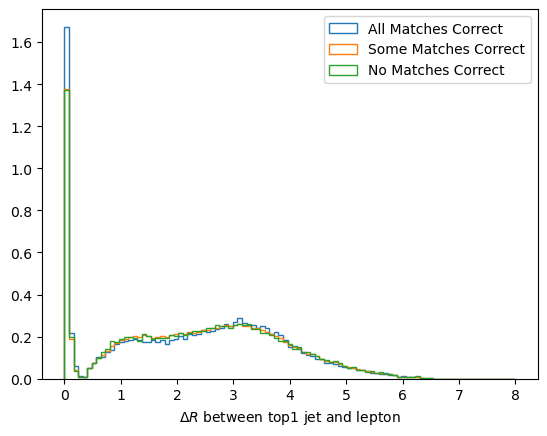

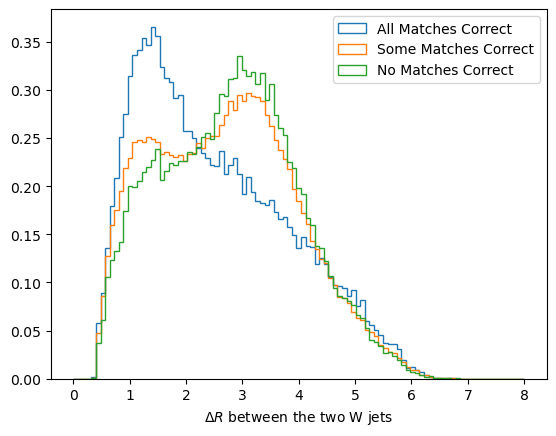

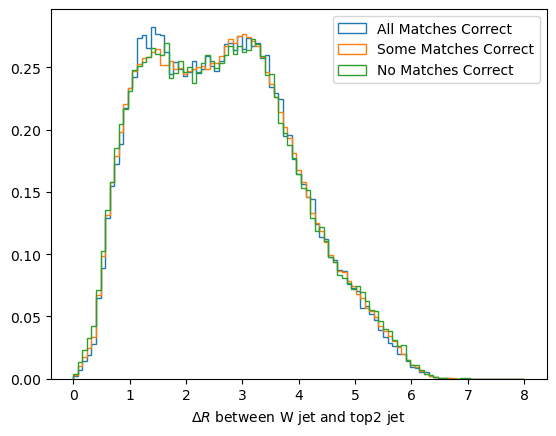

In [15]:
#### delta R plots ####

bins = np.linspace(0,8,100)
legend_list = ["All Matches Correct", "Some Matches Correct", "No Matches Correct"]
plt.hist(all_correct[:,0], histtype='step', bins=bins, density=True)
plt.hist(some_correct[:,0], histtype='step', bins=bins, density=True)
plt.hist(none_correct[:,0], histtype='step', bins=bins, density=True)
plt.legend(legend_list)
plt.xlabel("$\Delta R$ between top1 jet and lepton")
plt.show()

plt.hist(all_correct[:,1], histtype='step', bins=bins, density=True)
plt.hist(some_correct[:,1], histtype='step', bins=bins, density=True)
plt.hist(none_correct[:,1], histtype='step', bins=bins, density=True)
plt.legend(legend_list)
plt.xlabel("$\Delta R$ between the two W jets")
plt.show()

plt.hist(np.concatenate((all_correct[:,2],all_correct[:,3])), histtype='step', bins=bins, density=True)
plt.hist(np.concatenate((some_correct[:,2],some_correct[:,3])), histtype='step', bins=bins, density=True)
plt.hist(np.concatenate((none_correct[:,2],none_correct[:,3])), histtype='step', bins=bins, density=True)
plt.legend(legend_list)
plt.xlabel("$\Delta R$ between W jet and top2 jet")
plt.show()

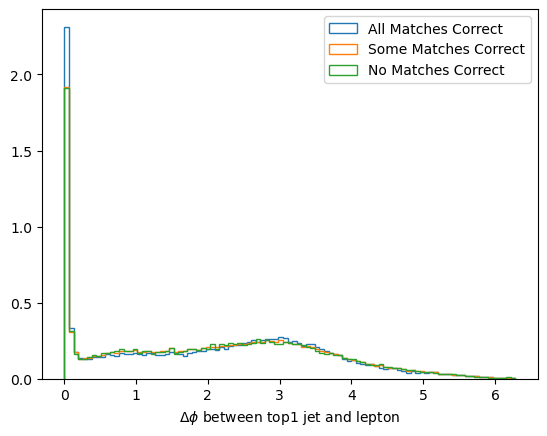

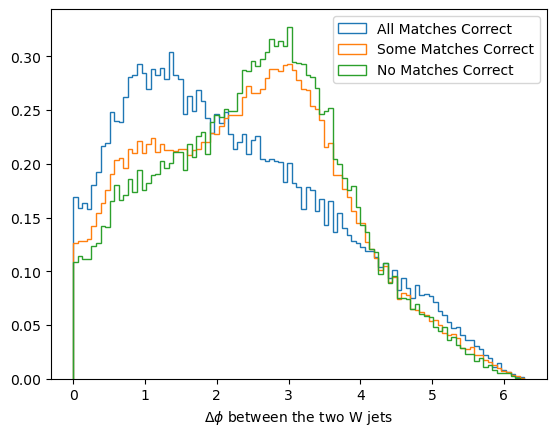

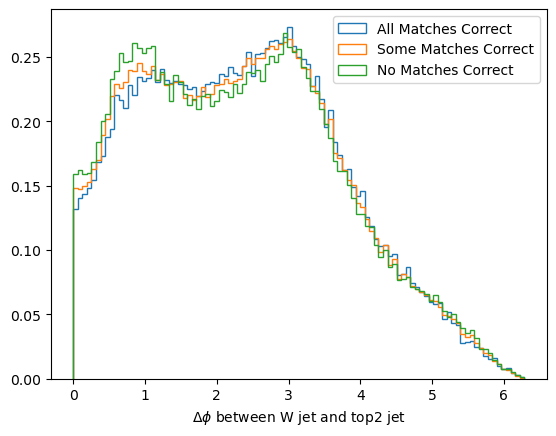

In [16]:
#### delta phi plots ####

bins = np.linspace(0,2*np.pi,100)
legend_list = ["All Matches Correct", "Some Matches Correct", "No Matches Correct"]

plt.hist(all_correct[:,4], histtype='step', bins=bins, density=True)
plt.hist(some_correct[:,4], histtype='step', bins=bins, density=True)
plt.hist(none_correct[:,4], histtype='step', bins=bins, density=True)
plt.legend(legend_list)
plt.xlabel("$\Delta\phi$ between top1 jet and lepton")
plt.show()

plt.hist(all_correct[:,5], histtype='step', bins=bins, density=True)
plt.hist(some_correct[:,5], histtype='step', bins=bins, density=True)
plt.hist(none_correct[:,5], histtype='step', bins=bins, density=True)
plt.legend(legend_list)
plt.xlabel("$\Delta\phi$ between the two W jets")
plt.show()

plt.hist(np.concatenate((all_correct[:,6],all_correct[:,7])), histtype='step', bins=bins, density=True)
plt.hist(np.concatenate((some_correct[:,6],some_correct[:,7])), histtype='step', bins=bins, density=True)
plt.hist(np.concatenate((none_correct[:,6],none_correct[:,7])), histtype='step', bins=bins, density=True)
plt.legend(legend_list)
plt.xlabel("$\Delta\phi$ between W jet and top2 jet")
plt.show()

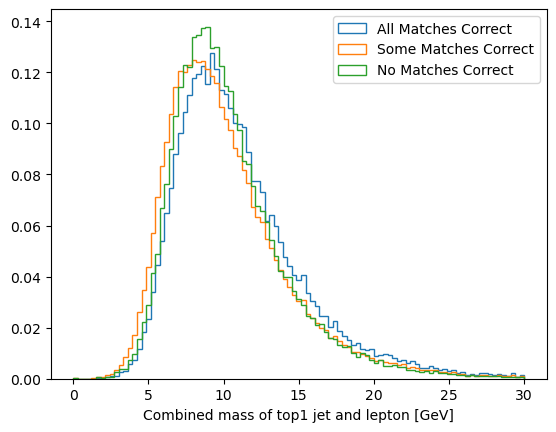

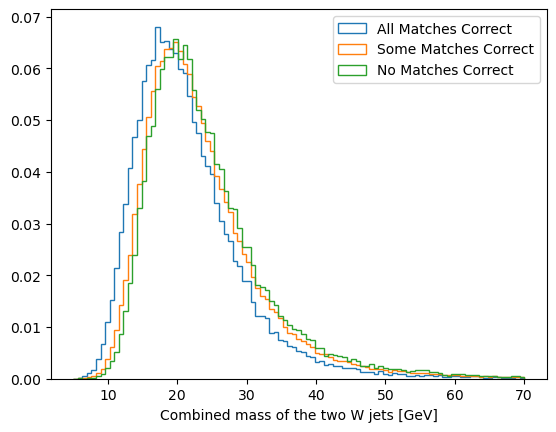

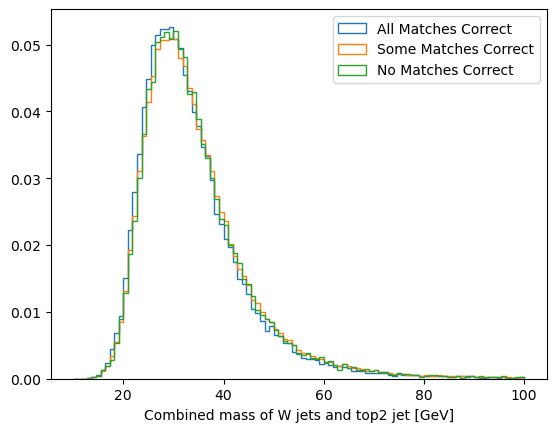

In [17]:
#### mass plots ####
legend_list = ["All Matches Correct", "Some Matches Correct", "No Matches Correct"]

bins = np.linspace(0,30,100)
plt.hist(all_correct[:,8], histtype='step', bins=bins, density=True)
plt.hist(some_correct[:,8], histtype='step', bins=bins, density=True)
plt.hist(none_correct[:,8], histtype='step', bins=bins, density=True)
plt.legend(legend_list)
plt.xlabel("Combined mass of top1 jet and lepton [GeV]")
plt.show()

bins = np.linspace(5,70,100)
plt.hist(all_correct[:,9], histtype='step', bins=bins, density=True)
plt.hist(some_correct[:,9], histtype='step', bins=bins, density=True)
plt.hist(none_correct[:,9], histtype='step', bins=bins, density=True)
plt.legend(legend_list)
plt.xlabel("Combined mass of the two W jets [GeV]")
plt.show()

bins = np.linspace(10,100,100)
plt.hist(all_correct[:,10], histtype='step', bins=bins, density=True)
plt.hist(some_correct[:,10], histtype='step', bins=bins, density=True)
plt.hist(none_correct[:,10], histtype='step', bins=bins, density=True)
plt.legend(legend_list)
plt.xlabel("Combined mass of W jets and top2 jet [GeV]")
plt.show()

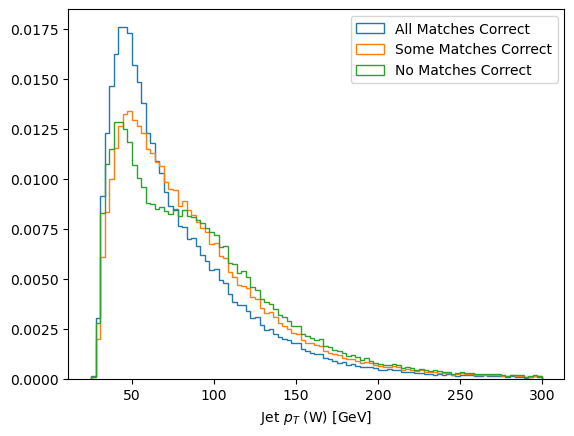

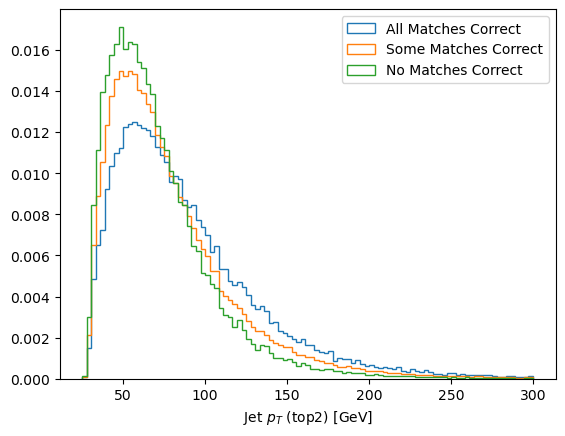

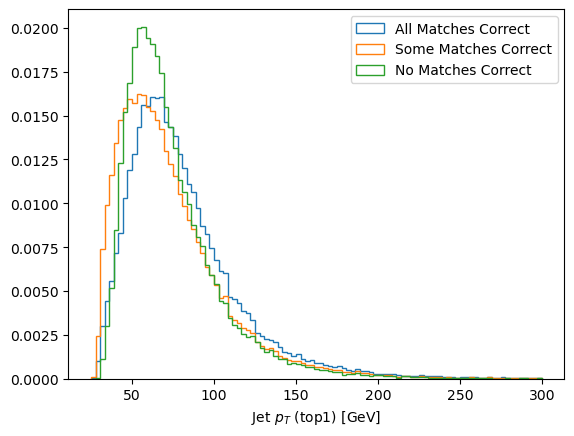

In [20]:
#### pT plots ####
legend_list = ["All Matches Correct", "Some Matches Correct", "No Matches Correct"]
bins = np.linspace(25,300,100)

plt.hist(np.concatenate((all_correct[:,11],all_correct[:,12])), histtype='step', bins=bins, density=True)
plt.hist(np.concatenate((some_correct[:,11],some_correct[:,12])), histtype='step', bins=bins, density=True)
plt.hist(np.concatenate((none_correct[:,11],none_correct[:,12])), histtype='step', bins=bins, density=True)
plt.legend(legend_list)
plt.xlabel("Jet $p_T$ (W) [GeV]")
plt.show()

plt.hist(all_correct[:,13], histtype='step', bins=bins, density=True)
plt.hist(some_correct[:,13], histtype='step', bins=bins, density=True)
plt.hist(none_correct[:,13], histtype='step', bins=bins, density=True)
plt.legend(legend_list)
plt.xlabel("Jet $p_T$ (top2) [GeV]")
plt.show()

plt.hist(all_correct[:,14], histtype='step', bins=bins, density=True)
plt.hist(some_correct[:,14], histtype='step', bins=bins, density=True)
plt.hist(none_correct[:,14], histtype='step', bins=bins, density=True)
plt.legend(legend_list)
plt.xlabel("Jet $p_T$ (top1) [GeV]")
plt.show()

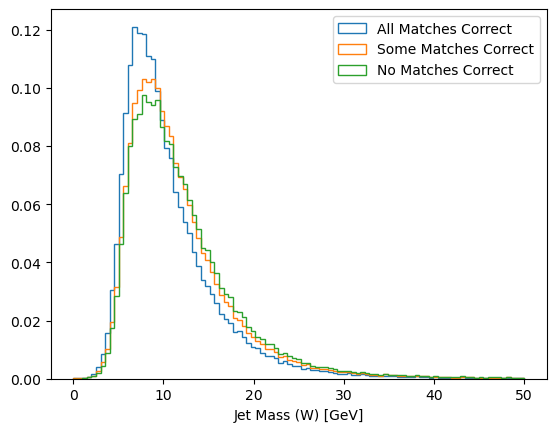

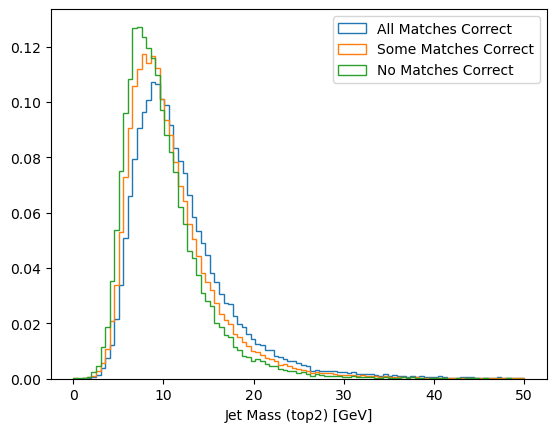

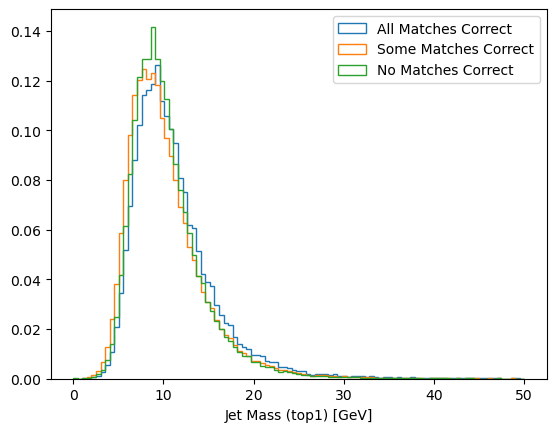

In [21]:
#### jet mass plots ####
legend_list = ["All Matches Correct", "Some Matches Correct", "No Matches Correct"]

bins = np.linspace(0,50,100)
plt.hist(np.concatenate((all_correct[:,15],all_correct[:,16])), histtype='step', bins=bins, density=True)
plt.hist(np.concatenate((some_correct[:,15],some_correct[:,16])), histtype='step', bins=bins, density=True)
plt.hist(np.concatenate((none_correct[:,15],none_correct[:,16])), histtype='step', bins=bins, density=True)
plt.legend(legend_list)
plt.xlabel("Jet Mass (W) [GeV]")
plt.show()

bins = np.linspace(0,50,100)
plt.hist(all_correct[:,17], histtype='step', bins=bins, density=True)
plt.hist(some_correct[:,17], histtype='step', bins=bins, density=True)
plt.hist(none_correct[:,17], histtype='step', bins=bins, density=True)
plt.legend(legend_list)
plt.xlabel("Jet Mass (top2) [GeV]")
plt.show()

bins = np.linspace(0,50,100)
plt.hist(all_correct[:,18], histtype='step', bins=bins, density=True)
plt.hist(some_correct[:,18], histtype='step', bins=bins, density=True)
plt.hist(none_correct[:,18], histtype='step', bins=bins, density=True)
plt.legend(legend_list)
plt.xlabel("Jet Mass (top1) [GeV]")
plt.show()